# Post-buckling of a simply-supported beam

In this notebook we show how to solve the problem of the buckling of the simply supported beam with built-in FEniCS feaures to solve nonlinear problem: automatic symbolic differentiation and newton solvers. 

The work asked in TP 2.2 is to provide your own implementation of the newton solver and to do not use automatic differentiation. This is to be able to understand in details the steps required to solve a nonlinear problem within a finite element code

## Basic import and functions for plotting the shapes 

In [3]:
from fenics import * 
parameters.plotting_backend = "matplotlib"
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The following functions are require to plot the shape $(x(s),y(s))$ given the field $\theta(s)$ (see the TP text) 

In [4]:
def xy_shape(theta):
    VXY = VectorFunctionSpace(mesh,'P',1,dim = 2)
    (X,Y) = TrialFunctions(VXY)
    (X_chap,Y_chap) = TestFunctions(VXY)
    bc = DirichletBC(VXY, (0.,0.), "x[0] == 0.")
    a_x = X.dx(0)*X_chap*dx
    L_x = cos(theta)*X_chap*dx
    a_y = Y.dx(0)*Y_chap*dx
    L_y = sin(theta)*Y_chap*dx
    xy = Function(VXY)
    solve(a_x + a_y == L_x + L_y, xy, bc)
    return xy

def xy_vertex_values(xy):
    (xs,ys) = xy.split(deepcopy=True) 
    xsv = xs.compute_vertex_values()
    ysv = ys.compute_vertex_values()
    return (xsv, ysv)

def plot_shape(theta):
    (xsv, ysv) = xy_vertex_values(xy_shape(theta))
    myplot = plt.plot(xsv,ysv)
    plt.ylim([-1.,1.])
    plt.xlim([-1.,1.])
    return myplot

## Mesh and definition of function spaces
We use here the 'elastica' inextensible model and the rotation field $\theta$ is used to describe the configuration

In [6]:
mesh = UnitIntervalMesh(50)
element = FiniteElement("CG", interval, 1)
V = FunctionSpace(mesh, element)
theta = Function(V)
thetat = TestFunction(V)
delta_theta = TrialFunction(V)

The following function solve the problem for a given loading $t$  and initial curvature $k_0$. We suppose here that the initial curvature in uniform in space. 
Moreover note that we make use of the function in FEniCS (UFL componenent) to do symbolically the directional derivative of a function (see https://fenicsproject.org/documentation/dolfin/dev/python/programmers-reference/fem/formmanipulations/derivative.html and the FEniCS documentation). See also Chapter 3 of the second volume of the  FEnics tutorial.

To simplify the formulation when using the $\theta$ variable to describe the shape, we assume that the deformed shape is symmetric and we consider only half-beam, with rotation null in $x=0$ and free in $x=1$. 

In [7]:
def solve_beam(tv, k0v):
    lmbda = Expression("t", t=tv, degree=0)
    k0 = Expression("k0", k0=k0v, degree=0)
    energy = (1./2.*(theta.dx(0)-k0)**2+lmbda*sin(theta))*dx
    energy_theta = derivative(energy, theta, thetat)
    energy_theta_theta = derivative(energy_theta, theta, delta_theta)
    bcs = DirichletBC(V, pi/2., "x[0]<1e-8")
    problem = NonlinearVariationalProblem(energy_theta, theta, bcs=bcs, J=energy_theta_theta)
    solver = NonlinearVariationalSolver(problem)
    solver.solve()
    return theta

This solves the problem for different values of the applied force, for a given initial curvature. 
The line `theta = interpolate(Expression("pi/2.+k0*x[0]",k0=-0.,degree=1),V)` serves to give the starting point for the Netwon algorithm. Note that the `k0` there is not necassary the one we put in the energy.

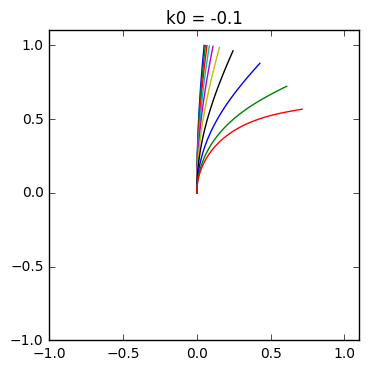

In [8]:
theta = interpolate(Expression("pi/2.+k0*x[0]",k0=-0.,degree=1),V)
loadings = np.linspace(0,3,10)
thetaL = 0*loadings
fig = plt.figure()
k0v = -.1
for (i, load) in enumerate(loadings):
    theta = solve_beam(load,k0v)
    (xsv, ysv) = xy_vertex_values(xy_shape(theta))
    ax = fig.add_subplot(111)
    ax.plot(xsv,ysv,'-')
    plt.ylim([-1.,1.1])
    plt.xlim([-1.,1.1])
    ax.set_aspect('equal')
    ax.set_title("k0 = %s"%k0v)

Have fun playing with that, and use also your own netwon solver!